In [5]:
from Peak_Search_Linien import LinienDevice
from windfreak import SynthHD
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from linien_utils import get_waveform, set_scan_range
from linien_client.connection import LinienClient
from scipy.signal import find_peaks

import statistics
import time
import tqdm
import csv
resource_name_windfreak = "COM8"
try:
    synthd = SynthHD(resource_name_windfreak)
    synthd.init()
except:
    pass
rf_out = 0
c = LinienDevice(
    host="10.10.222.36",
    user="root",
    password="root"
)
# c.connect(autostart_server=True, use_parameter_cache=True)


linien_client.connection       INFO     Try to connect to 10.10.222.36:18862
linien_client.connection       INFO     Connection established!


Peak Search

In [7]:
for j in range(4,10):
    zero_amp_all = []
    fir_amp_all = []
    pow_max_all = []
    scan_data = []
    power_scan = np.linspace(-20, 10, 100)
    fre_scan = np.linspace(1700e6,2700e6,100)

    fir_amps = []
    synthd[rf_out].enable = False
    time.sleep(1)
    c.ini_peak_search()
    synthd[rf_out].enable = True

    i=0
    while i < len(fre_scan):
        fre_scan_start = time.time()
        rf_fre = fre_scan[i]
        fir_amp = []
        sweep_center = []
        set_scan_range(c.client, 0, 0.6)     
        synthd[rf_out].frequency = rf_fre
        if rf_fre > 2300 and rf_fre > 2450:
            synthd[rf_out].power = -18
        elif rf_fre > 2450:
            synthd[rf_out].power = -14
        else:
            synthd[rf_out].power = -20
        time.sleep(0.5)
        c.mod_peak_search(first_search=True)
        c.zero_measure()

        c.sweep_center = 0
        c.fir_measure(rf_fre)
        if c.fir_amp < 10: # could not find peak
            continue
        if abs(c.fir_amp - c.mod_zero_amp) < abs(c.fir_amp): # found the 0th order peak
            continue
        if c.fir_amp >= 1000: # found the 0th order peak
            continue
        for shdpower in tqdm.tqdm(power_scan):
            start = time.time()
            synthd[rf_out].power = shdpower
            c.fir_measure(rf_fre)
            if len(fir_amp) >= 2:
                while abs(fir_amp[-1]-c.fir_amp) > 0.2 * fir_amp[-1] and abs(fir_amp[-1]-c.fir_amp) > 0.2*fir_amp[-1]:  # measurement is very off
                    c.fir_measure(rf_fre)
                    if time.time() - start > 5:
                        break
            fir_amp.append(c.fir_amp)

    
        if max(fir_amp) < 400 and time.time() - fre_scan_start < 600: # probably did not find the right peak, refind
            continue
        if time.time() - fre_scan_start > 600: # still did not find the right peak, just find the peak without any zooming
            set_scan_range(c.client, 0, 0.6)
            fir_amp = []
            for shdpower in tqdm.tqdm(power_scan):
                start = time.time()
                synthd[rf_out].power = shdpower
                c.fir_measure(rf_fre, zoom=False)
                if len(fir_amp) >= 2:
                    while abs(fir_amp[-1]-c.fir_amp)/fir_amp[-1] > 0.4 and abs(fir_amp[-1]-c.fir_amp)/fir_amp[-1] > 0.4:  # measurement is very off
                        c.fir_measure(rf_fre)
                        if time.time() - start > 5:
                            break
                fir_amp.append(c.fir_amp)
        pow_max = power_scan[fir_amp.index(max(fir_amp))]    
        scan_data.append([rf_fre,pow_max])
        fir_amps.append(fir_amp)
        pow_max_all.append(pow_max)
        fir_amp_all.append(fir_amp)
        i=i+1

    import pickle
    with open(f'2024_3_28_NLTL3_powerscan_10MHzstep_fir_amp_all-{j}.pickle', 'wb') as handle:
        pickle.dump(fir_amp_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

        

  6%|▌         | 6/100 [00:04<01:14,  1.27it/s]

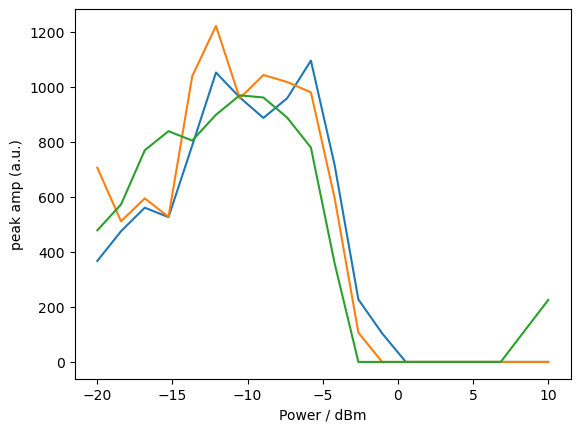

In [6]:
from scipy.signal import savgol_filter as sf

for i in range(0, 3):
    plt.plot(power_scan,sf(fir_amp_all[i],2,1),label = "first order")
    #plt.plot(power_scan,zero_amp_all[i],label = "zero order")
    plt.xlabel("Power / dBm")
    plt.ylabel("peak amp (a.u.)")

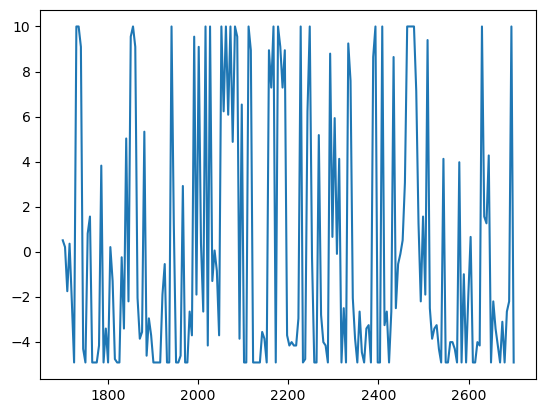

In [24]:
# from scipy.signal import savgol_filter as sf
# import numpy as np
# from scipy.signal import find_peaks
# import matplotlib.pyplot as plt
# power_scan = np.linspace(-20, 10, 200)
# fre_scan = np.linspace(1700,2700,200)
# pow_max_all=[]
# for i in range(200):
#     fir_amp = fir_amp_all[i]
#     fir_amp = fir_amp[100:]
#     fir_amp = sf(fir_amp, 30, 3)
#     posi = np.where(fir_amp==max(fir_amp))
#     posi = posi[0] + 100
#     # print(posi)
#     pow_max_all.append( power_scan[posi]    )

# plt.plot(fre_scan,pow_max_all)

In [ ]:
synthd[0].power=-5

IndexError: list index out of range

Text(0, 0.5, 'peak amp / mV')

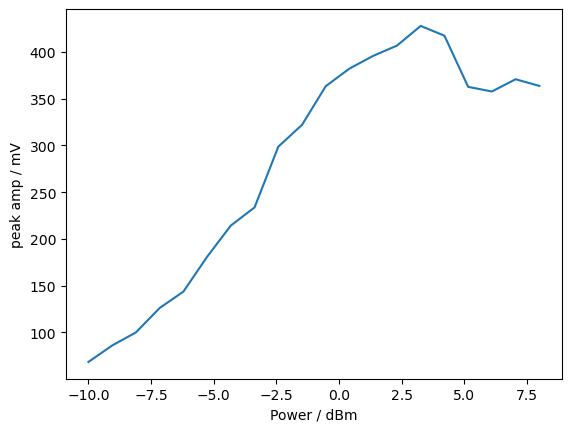

In [ ]:
plt.plot(power_scan,fir_amp_all[0],label = "first order")
#plt.plot(power_scan,zero_amp_all[20],label = "zero order")
plt.xlabel("Power / dBm")
plt.ylabel("peak amp / mV")

In [ ]:
synthd.close()